# 📝 Training of DistilRoBERTa + CatBoost with spell autocorrect and Feature Importance

<div style="font-family:Sans-serif; border-style: dotted;border-color:#254E58; border-width:2px; border-radius:20px; padding:10px;margin: 1px; text-align:left; width:40%; float:right; background-color:#b3d1ff; color:black;">
if you liked my notebook and found it useful, <span style="color:white; background-color:#9966ff; border-radius:2px; padding:2px">please consider upvoting it 🤍</span>. Your support means a lot and helps to spread the information to others.<i>Thank you for your time!</i>

In this notebook, I've brought together two great works on [feature engineering](https://www.kaggle.com/code/vassylkorzh/feature-engineering) and [building Debertav3+LGBM model with spell autocorrect ](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect). If you haven't seen them yet, I highly recommend it! Also I tried to make the code design as readable as possible (not counting feature engineering). I hope you like it!

<center>As a result, practically out of the box, this pipeline gives the following CV result:</center>
<br>

|                       | content rmse | wording rmse | mcrmse |
|-----------------------|:------------:|:------------:|:------:|
|DistilRoBERTa          |     0.546    |     0.702    | 0.624  |
|DistilRoBERTa+CatBoost |     0.490    |     0.607    | 0.548  |


## Model Pipeline

- Instead of using `Debertav3` I chose `DistilRoBERTa` because their performance is virtually indistinguishable, but the latter model is noticeably faster to train.
- After LLM + CatBoost training I propose a way to analyze the Feature Importance using `Shapley Values` and select the most significant features. It can effectively reduce overfitting and improve LB score.
- At the end, I suggest to see how you can tune the hyperparameters of the CatBoost model with the help of `optuna`

## Feature Engineering

The features are almost unchanged from the ones used in [this notebook](https://www.kaggle.com/code/vassylkorzh/feature-engineering). I'll use the following features.

- Text length
    - prompt_length
    - corrected summary length
    - length ratio
- Word overlap ratio
- N-grams Co-occurrence
    - overlap ratio
    - repetitions
- Quotes overlap ratio
- Semantic similarity
- spelling: pyspellchecker
- Advanced vocabulary
    - prompt difficult words count
    - summary difficult words count
    - difficult words overlap ratio


In [ ]:
!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

In [3]:
import numpy as np 
import pandas as pd
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from catboost import CatBoostRegressor

import random
import os
import warnings
import logging
import shutil
from tqdm import tqdm
from datasets import disable_progress_bar
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()


# SEED 102
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(102)

# Main LLM Config

In [4]:
class CFG:
    model_name="distilroberta-base"
    model_path=f"/kaggle/input/roberta-transformers-pytorch/{model_name}"
    learning_rate = 5e-5
    weight_decay = 0.02
    hidden_dropout_prob=0.001
    attention_probs_dropout_prob=0.001
    num_train_epochs=5
    n_splits=4
    batch_size=32
    warmup_steps=200
    max_length=512

# Data

In [5]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

# Features

I put together many of the features from the wonderful notebook [feature-engineering](https://www.kaggle.com/code/vassylkorzh/feature-engineering). Be sure to check it out!

It is important to note that we create `corrected_summary_text` in order to pass the LLM model for content regression 
(I won't elaborate on the features since you can see the source.)

In [82]:
def extract_features(summaries_df, prompt_df, save_path):
    tokenizer = AutoTokenizer.from_pretrained(CFG.model_path)

    full_data = pd.merge(summaries_df, prompt_df, on='prompt_id')
    full_data = full_data.applymap(lambda s: s.lower() if type(s) == str else s)

    # add corrected summary
    from autocorrect import Speller
    from spellchecker import SpellChecker
    speller      = Speller(lang='en')
    spellchecker = SpellChecker() 
    def _tokenize(row):
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(row), skip_special_tokens=True)
        return [token.lower() for token in tokens]
    def _add_spell_dict(tokens):
        spellchecker.word_frequency.load_words(tokens)
        speller.nlp_data.update({token:1000 for token in tokens})
    full_data["prompt_text"].apply(_tokenize).progress_apply(lambda x: _add_spell_dict(x))
    full_data["corrected_summary_text"] = full_data["text"].progress_apply(speller)  
    print("corrected_summary_text is done")

    # prompt length
    tmp_prompt_length_df = full_data.groupby('prompt_id').prompt_text.first().transform(
        lambda x: len(tokenizer.encode(x))).reset_index().rename(columns={'prompt_text': 'prompt_length'})
    full_data = pd.merge(full_data, tmp_prompt_length_df, on='prompt_id')

    # length ratio
    def count_text_length(df, col, tokenizer=tokenizer):
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))
    full_data['corrected_summary_length'] = count_text_length(full_data, 'corrected_summary_text')
    full_data['length_ratio'] = full_data['corrected_summary_length'] / full_data['prompt_length']
    print('length_ratio is done')

    # word overlap in prompt_text and corrected_summary_text
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    nltk.download('stopwords')
    nltk.download('punkt')
    STOP_WORDS = set(stopwords.words('english'))
    def word_overlap_ratio(row, stop_words=STOP_WORDS):
        def check_is_stop_word(word):
            return word not in stop_words
        prompt_words  = set(word_tokenize(row['prompt_text']))
        summary_words = set(word_tokenize(row['corrected_summary_text']))
        if stop_words:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        intersection = set(prompt_words).intersection(set(summary_words))
        overlap_ratio = len(intersection)/len(summary_words) if len(summary_words) else 0
        return overlap_ratio, len(intersection)
    full_data['word_overlap_ratio'] = full_data.progress_apply(lambda x: word_overlap_ratio(x)[0], axis=1)
#     full_data['word_overlap_count'] = full_data.progress_apply(lambda x: word_overlap_ratio(x)[1], axis=1)
    print('word_overlap is done')

    # ratio of common n-grams between prompt_text and corrected_summary_text to the summary_text
    from nltk import ngrams
    from nltk.tokenize import word_tokenize
    from collections import Counter
    def ngram_co_occurrence(row, n):
        original_tokens = word_tokenize(row['prompt_text'])
        summary_tokens  = word_tokenize(row['corrected_summary_text'])
        original_ngrams = set(ngrams(original_tokens, n))
        summary_ngrams  = set(ngrams(summary_tokens, n))
        common_ngrams = original_ngrams.intersection(summary_ngrams)
        return len(common_ngrams)/len(summary_ngrams) if len(summary_ngrams) else 0, len(common_ngrams)
    full_data['bigram_overlap_ratio']  = full_data.progress_apply(lambda x: ngram_co_occurrence(x,2)[0], axis=1 )
    full_data['trigram_overlap_ratio'] = full_data.progress_apply(lambda x: ngram_co_occurrence(x,3)[0], axis=1 )
#     full_data['bigram_overlap_count']  = full_data.progress_apply(lambda x: ngram_co_occurrence(x,2)[1], axis=1 )
#     full_data['trigram_overlap_count'] = full_data.progress_apply(lambda x: ngram_co_occurrence(x,3)[1], axis=1 )
    print('ngram_overlap is done')

    # ratio of quotes in intersection(corrected_summary_text, prompt_text) to prompt_text
    import re
    def quotes_count(row):
        summary = row['corrected_summary_text']
        text    = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        quotes_from_text   = re.findall(r'"([^"]*)"', text   )
        return [quote in text for quote in quotes_from_summary].count(True)
    full_data['quotes'] = full_data.progress_apply(quotes_count, axis=1)
    print('quotes_ratio is done')

    # misspells in text ### may be use unique misspelling idk!
    def get_misspell_count(text):
        tokens = nltk.word_tokenize(text)
        mis_tokens = [token for token in spellchecker.unknown(tokens) if token.isalpha()]
        return len(mis_tokens)
    full_data['ERR_MISSPELL'] = full_data['text'].apply(lambda x: get_misspell_count(x))
    print('ERR_MISSPELL is done')

    # semantic similarity using distilroberta-base
    from sentence_transformers import SentenceTransformer, util
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embeddings_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1', device=device)
    prompt_to_emb_dict = full_data.groupby('prompt_id')['prompt_text'].first().transform(
        lambda x: embeddings_model.encode(x, batch_size=1, show_progress_bar=False)).to_dict()
    def semantic_similarity(row, model=embeddings_model, prompt_embeddings=prompt_to_emb_dict):
        prompt_vector = prompt_embeddings[row['prompt_id']]
        summary_vector = model.encode(row['corrected_summary_text'], batch_size=1, show_progress_bar=False)
        return util.cos_sim([prompt_vector], [summary_vector]).item()
    full_data['semantic_similarity'] = full_data.progress_apply(semantic_similarity, axis=1)
    print('semantic_similarity is done')

    # advanced vocabulary
    from nltk import word_tokenize
    word_difficulty = pd.read_csv('/kaggle/input/word-difficulty/WordDifficulty.csv')
    difficult_words_list = word_difficulty.loc[word_difficulty['I_Zscore'] > 0]
    difficult_words_list = difficult_words_list.Word.unique().tolist()
    def get_difficult_words(text):
        def _filter_difficult_words(words):
            return [word for word in words if word in difficult_words_list]
        words = [word for word in word_tokenize(text) if word not in STOP_WORDS]
        return set(_filter_difficult_words(words)), words
    PROMPT_DIFFICULT_WORDS = full_data.groupby('prompt_id').prompt_text.first().apply(lambda x: get_difficult_words(x)[0])
    def get_difficult_words_stats(row):
        prompt_id = row['prompt_id']
        summary   = row['corrected_summary_text']
        summary_difficult_words, all_words = get_difficult_words(summary)
        prompt_difficult_words = PROMPT_DIFFICULT_WORDS[prompt_id]
        difficult_words_overlap = len(prompt_difficult_words.intersection(summary_difficult_words))
        return {
            "summary_difficult_words_count": len(summary_difficult_words),
            "prompt_difficult_words_count": len(prompt_difficult_words),
            "difficult_words_overlap": difficult_words_overlap,
            "difficult_words_ratio": (len(summary_difficult_words) / len(all_words))*100 if len(all_words) else 0,
        }
    summaries_difficult_words_stats_df = full_data.progress_apply(lambda x: pd.Series(get_difficult_words_stats(x)), axis=1)
    summaries_difficult_words_stats_df.columns = ['ADV_'+str(col) for col in summaries_difficult_words_stats_df.columns.values]
    full_data = pd.concat([full_data, summaries_difficult_words_stats_df], axis=1)
    print('advanced vocab is done')

    # repetitions
    from nltk import ngrams
    from nltk.tokenize import word_tokenize
    from collections import Counter
    def count_repetitions(text, n):
        summary_tokens = word_tokenize(text)
        summary_ngrams = list(ngrams(summary_tokens, n))
        unique_ngrams = set(summary_ngrams)
        ngrams_count = dict(Counter(summary_ngrams))
        repetitive_ngrams = {k: v for k, v in ngrams_count.items() if v > 1}
        return len(repetitive_ngrams) / len(unique_ngrams)
    full_data['bigram_repetitions']  = full_data.progress_apply(lambda x: count_repetitions(x['corrected_summary_text'], 2), axis=1)
    full_data['trigram_repetitions'] = full_data.progress_apply(lambda x: count_repetitions(x['corrected_summary_text'], 3), axis=1)
    print('repetitions is done')

    full_data.to_csv(save_path, index=False)

'''
Spoiler: after analysing Feature Importance (Shapley Values) I threw out these features:
"quotes", "bigram_repetitions", "trigram_repetitions", all starting with "ADV_...", 
and even "ERR_MISPELL"!
'''

extract_features(summaries_train,prompts_train,save_path='./train.csv')
extract_features(summaries_test, prompts_test, save_path='./test.csv' )
train = pd.read_csv('./train.csv')
test  = pd.read_csv('./test.csv' )

## Correlation matrix

Before training it could be helpful to see how features correlate with targets:

In [76]:
targets = ['content', 'wording']
str_cols = ['student_id', 'prompt_id', 'text', 'prompt_question', 'prompt_title', 'prompt_text', 'corrected_summary_text']
inputs = [i for i in train.columns if i not in targets+str_cols]
corr = train.corr().loc[set(features)-set(['content_pred','wording_pred']),targets]
corr.style.background_gradient(cmap='coolwarm')

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


,content,wording
trigram_repetitions,0.199873,0.148046
semantic_similarity,0.497227,0.272106
trigram_overlap_ratio,-0.008359,-0.300131
quotes_ratio,0.133229,0.011594
ADV_prompt_difficult_words_count,-0.003555,0.055743
ADV_difficult_words_overlap_ratio,0.375592,0.120202
ERR_MISSPELL,0.247563,0.163713
bigram_repetitions,0.349078,0.266718
prompt_length,-0.047666,-0.152978
corrected_summary_length,0.778159,0.510509


## Split train dataset on 4 folds based on "prompt_id"

In [30]:
gkf = GroupKFold(n_splits=CFG.n_splits)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

# LLM initialisation + Trainer

`LLMRegressor` is a class for our LLM model which will train on received train_df and valid_df, after which we will save the trained model to the model_dir. 

`LLMRegressor.predict` method gets model from model_dir and returns predictions for test_df.

In [31]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

class LLMRegressor:
    def __init__(self, model_dir, target, config):
        seed_everything(seed=102)
        self.config      = config
        self.target      = target
        self.model_dir   = model_dir
        self.input_col   = "input"
        
        # Here we use the corrected spelling when predicting target=content
        self.summary_col = "corrected_summary_text" if target == "content" else "text"
    
        self.tokenizer    = AutoTokenizer.from_pretrained(self.config.model_path)
        self.model_config =    AutoConfig.from_pretrained(self.config.model_path)

        self.model_config.update({
            "num_labels": 1,
            "hidden_dropout_prob": config.hidden_dropout_prob,
            "attention_probs_dropout_prob": config.attention_probs_dropout_prob})
        
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        
    def train(self,fold,train_df,valid_df): # fine-tuning     
        
        sep = self.tokenizer.sep_token
        train_df[self.input_col] = (  train_df["prompt_title"]    + sep 
                                    + train_df["prompt_question"] + sep 
                                    + train_df[self.summary_col])

        valid_df[self.input_col] = (  valid_df["prompt_title"]    + sep 
                                    + valid_df["prompt_question"] + sep 
                                    + valid_df[self.summary_col])

        train_tokenized_datasets = Dataset.from_dict(
            {**self.tokenizer(train_df[self.input_col].to_list(), truncation=True, padding=True,
                             max_length=self.config.max_length, return_tensors="pt"), 
             'labels': train_df[self.target]}
        )
        val_tokenized_datasets = Dataset.from_dict(
            {**self.tokenizer(valid_df[self.input_col].to_list(), truncation=True, padding=True,  
                             max_length=self.config.max_length, return_tensors="pt"), 
             'labels': valid_df[self.target]}
        )
        
        llm_model = AutoModelForSequenceClassification.from_pretrained(self.config.model_path, config=self.model_config)
        
        training_args = TrainingArguments(
            dataloader_drop_last   = True,
            load_best_model_at_end = True,
            greater_is_better      = False,
            report_to              = "none",
            metric_for_best_model  = "rmse",
            evaluation_strategy    = "epoch",
            save_strategy          = "epoch",
            save_total_limit       = 1,
            per_device_eval_batch_size  = self.config.batch_size,
            per_device_train_batch_size = self.config.batch_size,
            output_dir       = self.model_dir,
            learning_rate    = self.config.learning_rate,
            num_train_epochs = self.config.num_train_epochs,
            weight_decay     = self.config.weight_decay,
            warmup_steps     = self.config.warmup_steps)

        trainer = Trainer(
            model     = llm_model,
            args      = training_args,
            tokenizer = self.tokenizer,
            train_dataset   = train_tokenized_datasets,
            eval_dataset    = val_tokenized_datasets,
            compute_metrics = compute_metrics,
            data_collator   = self.data_collator)

        trainer.train()
        
        llm_model.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

    
    def predict(self, test_df, fold): # return predictions
        
        sep = self.tokenizer.sep_token
        test_df[self.input_col] = (  test_df["prompt_title"] + sep 
                                   + test_df["prompt_question"] + sep 
                                   + test_df[self.summary_col])
        
        test_tokenized_dataset = Dataset.from_dict(
            self.tokenizer(test_df[self.input_col].to_list(), truncation=True, padding=True,
                           max_length=self.config.max_length, return_tensors="pt") 
        )

        llm_model = AutoModelForSequenceClassification.from_pretrained(self.model_dir)
        llm_model.eval()

        test_args = TrainingArguments(
            output_dir = self.model_dir,
            do_predict = True,
            do_train   = False,
            dataloader_drop_last = False,
            per_device_eval_batch_size = 4)

        infer_content = Trainer(
                      model = llm_model,
                      args  = test_args,
                      tokenizer     = self.tokenizer,
                      data_collator = self.data_collator)

        return infer_content.predict(test_tokenized_dataset)[0]

## training on CV

Let's introduce useful functions for cross-validation learning:

1. `train_by_fold` just iterates by each CV fold, trains new model each time and save the model to the model_dir.

2. `validate` writes predictions (content_pred and wording_pred) into the train_df using models model_dir.

3. `predict` writes predictions into the test_df and since there is no split into folds for the test dataset we create coliumns "target_pred_fold"

In [36]:
def train_by_fold(train_df, target, save_each_model, config): # trains on folds, saves in /model/...
    
    if os.path.exists(config.model_name):
        shutil.rmtree(config.model_name)
    os.mkdir(config.model_name)
        
    for fold in range(config.n_splits):
        print(f"fold {fold}:")
        
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{config.model_name}/fold_{fold}"
        else: 
            model_dir =  f"{config.model_name}/fold_{fold}"

        LLM = LLMRegressor(target=target,model_dir=model_dir,config=config)
        
        LLM.train(fold=fold,train_df=train_data,valid_df=valid_data)

def validate(train_df, target, save_each_model, config): # writes predictions to target_pred of train_df
    for fold in range(config.n_splits):
        
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{config.model_name}/fold_{fold}"
        else: 
            model_dir =  f"{config.model_name}/fold_{fold}"
        
        LLM = LLMRegressor(target=target,model_dir=model_dir,config=config) # needed only for model_dir
        
        pred = LLM.predict(test_df=valid_data,fold=fold)
        
        train_df.loc[valid_data.index, f"{target}_pred"] = pred
        print(f"fold {fold}: done")
        
    return train_df
    
def predict(test_df,target,save_each_model,config): # returns predicts using mean by folds

    for fold in range(config.n_splits):
        print(f"fold {fold}:")
        
        if save_each_model == True:
            model_dir =  f"{target}/{config.model_name}/fold_{fold}"
        else: 
            model_dir =  f"{config.model_name}/fold_{fold}"
                    
        LLM = LLMRegressor(target=target,model_dir=model_dir,config=config) # needed only for model_dir
        
        pred = LLM.predict(test_df=test_df,fold=fold)
        
        test_df[f"{target}_pred_{fold}"] = pred
    
    test_df[target] = test_df[[f"{target}_pred_{fold}" for fold in range(config.n_splits)]].mean(axis=1)

    return test_df

## Training loop:

In [53]:
targets = ["content", "wording"]
    
for target in targets:
    train_by_fold(
        train_df = train,
        target   = target,
        config   = CFG,
        save_each_model = False)

    train = validate(
        train_df = train,
        target   = target,
        config   = CFG,
        save_each_model = False)

    rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
    print(f"cv {target} rmse: {rmse}")

    test = predict(
        test_df = test,
        target  = target,
        config  = CFG,
        save_each_model = True)

In [80]:
rmses = []
for target in targets:
    rmses.append(mean_squared_error(train[target], train[f'{target}_pred'], squared=False))
    print(f"LLM rmse on {target}: {rmses[-1]}")
print(f"\nmcrmse : {sum(rmses) / len(rmses)}")

LLM rmse on content: 0.5469204830065058
LLM rmse on wording: 0.7025075119436904

mcrmse : 0.6247139974750981


This is our first score! Lets see if we can improve the results using CatBoost

# Catboost

In [4]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", "corrected_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text"
               ] + targets

Implementation is straightforward

In [25]:
torch.cuda.empty_cache()

models_dict = {target:[] for target in targets} 
for target in targets:
    for fold in range(CFG.n_splits):
        print(f"fold: {fold}")
        
        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv  = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv  = train[train["fold"] == fold][target]
        
        model = CatBoostRegressor(
            learning_rate = 0.03,
            depth = 8,
            min_data_in_leaf = 34,
            iterations = 1200,
            task_type ='GPU',
            loss_function ='RMSE'
          )

        model.fit(
          X_train_cv, y_train_cv,
          eval_set=(X_eval_cv, y_eval_cv),
          silent = True
        );   
        models_dict[target].append(model)    
    

fold: 0
fold: 1
fold: 2
fold: 3
fold: 0
fold: 1
fold: 2
fold: 3


# CV score

In [27]:
rmses = []
for target in targets:
    preds = []
    trues = []
    for fold, model in enumerate(models_dict[target]):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)
        trues.extend(y_eval_cv)
        preds.extend(pred)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    rmses = rmses + [rmse]
    print(f"{target}_rmse : {rmse}")

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.49712996024057665
wording_rmse : 0.6051722065214629
mcrmse : 0.5511510833810198


So with CatBoost we got\
content_rmse: 0.54 $\rightarrow$ 0.49\
wording_rmse: 0.70 $\rightarrow$ 0.60


# Feature Importance, Shapley Values (optional)

To reduce the chance of overfitting, it is very useful to analyze the importance of features. If the latter model is based on trees, it would be natural to consider Shapeley Values (see [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html) for example of using violin summary plot)! 

feature importance for content:


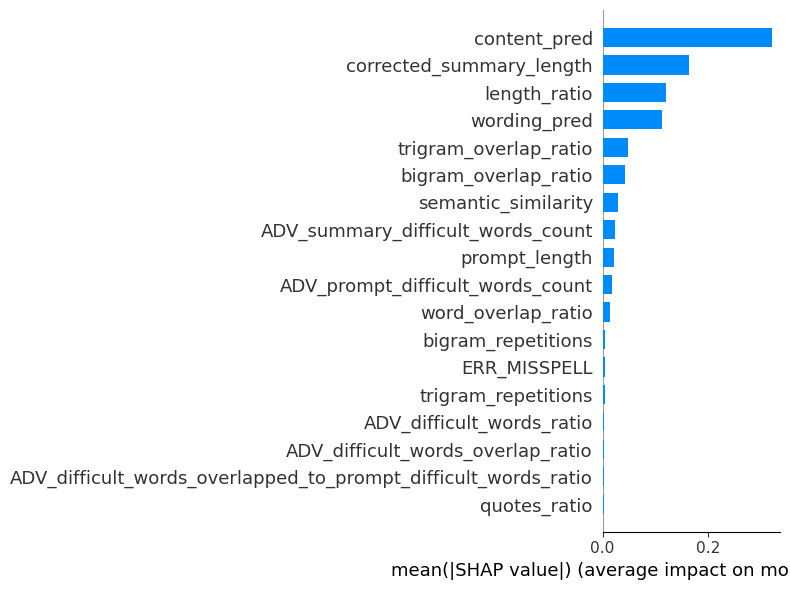


feature importance for wording:


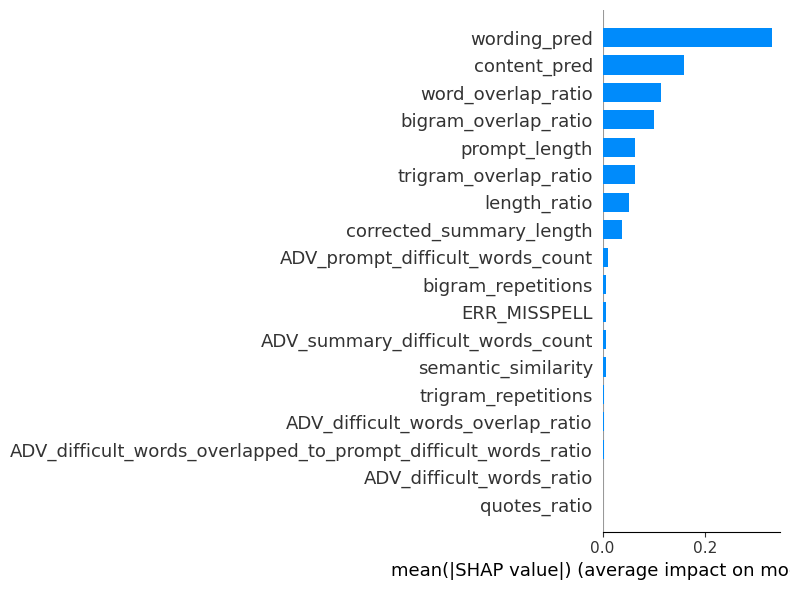

In [32]:
import shap
from catboost import Pool

def get_shap_vals(target, models_dict, **plot_args): # returns sorted by shap_value features
    shap_values = np.zeros((train.shape[0], train.shape[1]-len(drop_columns)))
    for fold in range(CFG.n_splits):
        X_train_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        explainer = shap.Explainer(models_dict[target][fold])
        shap_values[train["fold"]==fold] = explainer(X_train_cv).values
    print(f'feature importance for {target}:')
    shap.summary_plot(shap_values, train.drop(columns=drop_columns), **plot_args)
    print()
    return [x[1] for x in sorted(zip(np.abs(shap_values).mean(axis=0), X_train_cv.columns))]
    
content_features_importance = get_shap_vals(targets[0], models_dict, plot_type = 'bar', plot_size=0.25, max_display=train.shape[1])
wording_features_importance = get_shap_vals(targets[1], models_dict, plot_type = 'bar', plot_size=0.25, max_display=train.shape[1])

We can notice that a lot of features do not give any tangible contribution to the CV score.

Perhaps a useful next step would be to tune CatBoost hyperparameters using the optuna ([here](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/) is a cute guide how to do it).

Now lets cut off features that dont contribute to CV and try to train CatBoost again:

In [37]:
bad_features = {
    "content":content_features_importance[:8], 
    "wording":wording_features_importance[:9]
}

# Catboost again!
new_models_dict = {target:[] for target in targets}
for target in targets:
    for fold in range(CFG.n_splits):
#         print(f"fold: {fold}")
        
        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns+bad_features[target])
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv  = train[train["fold"] == fold].drop(columns=drop_columns+bad_features[target])
        y_eval_cv  = train[train["fold"] == fold][target]
        
        model = CatBoostRegressor(
            learning_rate = 0.03,
            depth = 8,
            min_data_in_leaf = 34,
            iterations = 1200,
            task_type ='GPU',
            loss_function ='RMSE'
          )

        model.fit(
          X_train_cv, y_train_cv,
          eval_set=(X_eval_cv, y_eval_cv),
          silent = True
        );   
        new_models_dict[target].append(model)  

# check CV, again
rmses = []
for target in targets:
    preds = []
    trues = []
    for fold, model in enumerate(new_models_dict[target]):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns+bad_features[target])
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)
        trues.extend(y_eval_cv)
        preds.extend(pred)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    rmses = rmses + [rmse]
    print(f"{target}_rmse : {rmse}")

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.49073019490703146
wording_rmse : 0.6071732493108448
mcrmse : 0.5489517221089382


There is no difference with previous results! This is understandable because we discarded features that did not affect the result for the CatBoost model. If you want to build a large complex model, it is very useful to select those features that influence the outcome rather than being noise. This can greatly reduce the chance of overfitting.

# Optuna (optional)

We can tune CatBoost hyperparameters such as number of trees (`iterations`), learning rate, tree depth, minimum number of training samples in a leaf (`min_data_in_leaf`). There are many more parameters that can be optimized, but it takes a lot of n_trials to achieve a solid configuration, so we will limit ourselves to the basic ones:

In [ ]:
from sklearn.model_selection import train_test_split
import optuna

def objective(trial, target):
    params = {
        "iterations"   : trial.suggest_int("iterations", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 5, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }
    preds = []
    trues = []
    for fold in range(CFG.n_splits):
        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns+bad_features[target])
        y_train_cv = train[train["fold"] != fold][target]
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns+bad_features[target])
        y_eval_cv = train[train["fold"] == fold][target]
        model = CatBoostRegressor(**params, silent=True, task_type='GPU', loss_function='RMSE')
        model.fit(X_train_cv, y_train_cv)
        pred = model.predict(X_eval_cv)
        trues.extend(y_eval_cv)
        preds.extend(pred)
    rmse = mean_squared_error(trues, preds, squared=False)
    return rmse

for target in targets:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, target), n_trials=30)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)

# PREDICT

In [73]:
features = list(set(train.columns)-set(drop_columns))

for target in targets:
    test[f'{target}_pred'] = test[target]
    
pred_dict = {}
for target in targets:
    preds = []
    for fold, model in enumerate(models_dict[target]):
        X_eval_cv = test[features]
        pred = model.predict(X_eval_cv)
        preds.append(pred)
    pred_dict[target] = preds

# replace with new predictions based on CatBoost model:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

# SUBMIT

In [ ]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)